# Premier League Predictor

Ana Sepetovska & Yuhong Zhang

The project is trying to predict the rank of each team in the Premier League for season 18-19. We are currently using the predictors with:
* Number of goals per season
* Number of wins per season
* Number of red and yellow cards
* Number of shots at target per season
* Market Value of team

and team rank as the target.

The data for the project is downloaded from the sites:

https://datahub.io/sports-data/english-premier-league

https://www.transfermarkt.co.uk/premier-league/startseite/wettbewerb/GB1/plus/?saison_id=2018

The original data is in the form of stats per game. A preprocessing is needed to convert the data to the format of stats per team per season.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = 16, 5
from sklearn import linear_model
stats = pd.read_csv('archive/season-0910.csv')

Populating the interactive namespace from numpy and matplotlib


In [2]:
stats.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,15/08/09,Aston Villa,Wigan,0,2,A,0,1,A,M Clattenburg,...,5,7,15,14,4,6,2,2,0,0
1,15/08/09,Blackburn,Man City,0,2,A,0,1,A,M Dean,...,9,5,12,9,5,4,2,1,0,0
2,15/08/09,Bolton,Sunderland,0,1,A,0,1,A,A Marriner,...,3,13,16,10,4,7,2,1,0,0
3,15/08/09,Chelsea,Hull,2,1,H,1,1,D,A Wiley,...,12,3,13,15,12,4,1,2,0,0
4,15/08/09,Everton,Arsenal,1,6,A,0,3,A,M Halsey,...,5,9,11,13,4,9,0,0,0,0


In [3]:
stats.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
       'HY', 'AY', 'HR', 'AR'],
      dtype='object')

In [4]:
st = stats[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HY','AY','HR','AY','HST','AST']]
st.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HY,AY,HR,AY,HST,AST
0,Aston Villa,Wigan,0,2,A,2,2,0,2,5,7
1,Blackburn,Man City,0,2,A,2,1,0,1,9,5
2,Bolton,Sunderland,0,1,A,2,1,0,1,3,13
3,Chelsea,Hull,2,1,H,1,2,0,2,12,3
4,Everton,Arsenal,1,6,A,0,0,0,0,5,9


In [5]:
# goalsHome = st.groupby(['HomeTeam'])['FTHG'].sum().reset_index().rename(columns={'HomeTeam': 'Club','FTHG': 'Total_FTHG'})

# goalsAway = st.groupby(['AwayTeam'])['FTAG'].sum().reset_index().rename(columns={'AwayTeam': 'Club','FTAG': 'Total_FTAG'})

# goalsTable = goalsHome.merge(goalsAway,on=['Club'])

# goalsTable['Total_G'] = goalsTable.Total_FTHG + table.Total_FTAG
# goalsTable.tail(n=20).sort_values('Total_G',ascending=False)


In [6]:
st['HomeTeamWon'] = st.apply(lambda row: 1 if row['FTR'] =='H' else 0, axis=1)
st['AwayTeamWon'] = st.apply(lambda row: 1 if row['FTR'] =='A' else 0, axis=1)
st['Draw'] = st.apply(lambda row: 1 if row['FTR'] =='D' else 0, axis=1)
st.head()

/home/yuhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/yuhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/yuhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HY,AY,HR,AY,HST,AST,HomeTeamWon,AwayTeamWon,Draw
0,Aston Villa,Wigan,0,2,A,2,2,0,2,5,7,0,1,0
1,Blackburn,Man City,0,2,A,2,1,0,1,9,5,0,1,0
2,Bolton,Sunderland,0,1,A,2,1,0,1,3,13,0,1,0
3,Chelsea,Hull,2,1,H,1,2,0,2,12,3,1,0,0
4,Everton,Arsenal,1,6,A,0,0,0,0,5,9,0,1,0


In [7]:
winsHome = st.groupby(['HomeTeam'])['HomeTeamWon'].sum().reset_index().rename(columns={'HomeTeam': 'Club', 'HomeTeamWon': 'Won'})

winsAway = st.groupby(['AwayTeam'])['AwayTeamWon'].sum().reset_index().rename(columns={'AwayTeam': 'Club', 'AwayTeamWon': 'Won'})

lossHome = st.groupby(['HomeTeam'])['AwayTeamWon'].sum().reset_index().rename(columns={'HomeTeam': 'Club', 'AwayTeamWon': 'Lost'})

lossAway = st.groupby(['AwayTeam'])['HomeTeamWon'].sum().reset_index().rename(columns={'AwayTeam': 'Club', 'HomeTeamWon': 'Lost'})

drawHome = st.groupby(['HomeTeam'])['Draw'].sum().reset_index().rename(columns={'HomeTeam': 'Club', 'Draw': 'Draw'})

drawAway = st.groupby(['AwayTeam'])['Draw'].sum().reset_index().rename(columns={'AwayTeam': 'Club', 'Draw': 'Draw'})


winsTable = winsHome.merge(winsAway, on=['Club']).merge(drawHome, on=['Club']).merge(drawAway, on=['Club']).merge(lossHome, on=['Club']).merge(lossAway, on=['Club'])
winsTable



,Club,Won_x,Won_y,Draw_x,Draw_y,Lost_x,Lost_y
0,Arsenal,15,8,2,4,2,7
1,Aston Villa,8,9,8,5,3,5
2,Birmingham,8,5,9,2,2,12
3,Blackburn,10,3,6,5,3,11
4,Bolton,6,4,6,3,7,12
5,Burnley,7,1,5,1,7,17
6,Chelsea,17,10,1,4,1,5
7,Everton,11,5,6,7,2,7
8,Fulham,11,1,3,7,5,11
9,Hull,6,0,6,6,7,13


In [8]:
winsTable = winsTable.rename(columns={'Won_x':'WinHome', 'Won_y':'WinAway', })
winsTable['Total_Won'] = winsTable.WinHome + winsTable.WinAway
winsTable['Total_Draw'] = winsTable.Draw_x + winsTable.Draw_y
winsTable['Total_Loss'] = winsTable.Lost_x + winsTable.Lost_y
winsTable = winsTable.drop(['Draw_x','Draw_y','Lost_x','Lost_y'],axis=1)


winsTable['Total_Played']=winsTable.Total_Won + winsTable.Total_Draw + winsTable.Total_Loss

winsTable

,Club,WinHome,WinAway,Total_Won,Total_Draw,Total_Loss,Total_Played
0,Arsenal,15,8,23,6,9,38
1,Aston Villa,8,9,17,13,8,38
2,Birmingham,8,5,13,11,14,38
3,Blackburn,10,3,13,11,14,38
4,Bolton,6,4,10,9,19,38
5,Burnley,7,1,8,6,24,38
6,Chelsea,17,10,27,5,6,38
7,Everton,11,5,16,13,9,38
8,Fulham,11,1,12,10,16,38
9,Hull,6,0,6,12,20,38


In [9]:
goalsHome = st.groupby(['HomeTeam'])['FTHG'].sum().reset_index().rename(columns={'HomeTeam': 'Club','FTHG': 'Total_FTHG'})

goalsAway = st.groupby(['AwayTeam'])['FTAG'].sum().reset_index().rename(columns={'AwayTeam': 'Club','FTAG': 'Total_FTAG'})


# HTS shots on target
shotsHome = st.groupby(['HomeTeam'])['HST'].sum().reset_index().rename(columns={'HomeTeam': 'Club','HST': 'Total_HST'})
shotsAway = st.groupby(['AwayTeam'])['AST'].sum().reset_index().rename(columns={'AwayTeam': 'Club','AST': 'Total_AST'})
goalsTable = goalsHome.merge(goalsAway,on=['Club']).merge(shotsHome, on=['Club']).merge(shotsAway, on=['Club'])

goalsTable['Total_G'] = goalsTable.Total_FTHG + goalsTable.Total_FTAG
goalsTable['Total_S'] = goalsTable.Total_HST + goalsTable.Total_AST
goalsTable.tail(n=20).sort_values('Total_G',ascending=False)

,Club,Total_FTHG,Total_FTAG,Total_HST,Total_AST,Total_G,Total_S
6,Chelsea,68,35,230,158,103,388
12,Man United,52,34,195,149,86,344
0,Arsenal,48,35,187,142,83,329
11,Man City,41,32,130,122,73,252
16,Tottenham,40,27,202,146,67,348
10,Liverpool,43,18,169,119,61,288
7,Everton,35,25,166,141,60,307
1,Aston Villa,29,23,121,118,52,239
15,Sunderland,32,16,119,97,48,216
17,West Ham,30,17,142,116,47,258


The data is eventually processed in the format of each team.

In [10]:
table = winsTable.merge(goalsTable, on=['Club'])
table.tail(n=20).sort_values('Total_G',ascending=False)

,Club,WinHome,WinAway,Total_Won,Total_Draw,Total_Loss,Total_Played,Total_FTHG,Total_FTAG,Total_HST,Total_AST,Total_G,Total_S
6,Chelsea,17,10,27,5,6,38,68,35,230,158,103,388
12,Man United,16,11,27,4,7,38,52,34,195,149,86,344
0,Arsenal,15,8,23,6,9,38,48,35,187,142,83,329
11,Man City,12,6,18,13,7,38,41,32,130,122,73,252
16,Tottenham,14,7,21,7,10,38,40,27,202,146,67,348
10,Liverpool,13,5,18,9,11,38,43,18,169,119,61,288
7,Everton,11,5,16,13,9,38,35,25,166,141,60,307
1,Aston Villa,8,9,17,13,8,38,29,23,121,118,52,239
15,Sunderland,9,2,11,11,16,38,32,16,119,97,48,216
17,West Ham,7,1,8,11,19,38,30,17,142,116,47,258


The point of each team is also calculated.

In [11]:
table['Points']=(table.Total_Won*3)+(table.Total_Draw*1)
table.tail(n=20).sort_values('Points',ascending=False)

,Club,WinHome,WinAway,Total_Won,Total_Draw,Total_Loss,Total_Played,Total_FTHG,Total_FTAG,Total_HST,Total_AST,Total_G,Total_S,Points
6,Chelsea,17,10,27,5,6,38,68,35,230,158,103,388,86
12,Man United,16,11,27,4,7,38,52,34,195,149,86,344,85
0,Arsenal,15,8,23,6,9,38,48,35,187,142,83,329,75
16,Tottenham,14,7,21,7,10,38,40,27,202,146,67,348,70
11,Man City,12,6,18,13,7,38,41,32,130,122,73,252,67
1,Aston Villa,8,9,17,13,8,38,29,23,121,118,52,239,64
10,Liverpool,13,5,18,9,11,38,43,18,169,119,61,288,63
7,Everton,11,5,16,13,9,38,35,25,166,141,60,307,61
3,Blackburn,10,3,13,11,14,38,28,13,140,98,41,238,50
2,Birmingham,8,5,13,11,14,38,19,19,109,111,38,220,50


In [12]:
# Avg goals per game . need total played 
# Red and yellow cards 
table['Avg_Goals'] = table.apply(lambda row: row['Total_G']/row['Total_Played'],axis=1)
# winsTable = winsTable.drop(['Draw_x','Draw_y','Lost_x','Lost_y'],axis=1)

preCards = table.drop(['Total_Loss','Total_Played'], axis=1)
preCards.tail(n=20).sort_values('Points',ascending=False)


,Club,WinHome,WinAway,Total_Won,Total_Draw,Total_FTHG,Total_FTAG,Total_HST,Total_AST,Total_G,Total_S,Points,Avg_Goals
6,Chelsea,17,10,27,5,68,35,230,158,103,388,86,2.710526
12,Man United,16,11,27,4,52,34,195,149,86,344,85,2.263158
0,Arsenal,15,8,23,6,48,35,187,142,83,329,75,2.184211
16,Tottenham,14,7,21,7,40,27,202,146,67,348,70,1.763158
11,Man City,12,6,18,13,41,32,130,122,73,252,67,1.921053
1,Aston Villa,8,9,17,13,29,23,121,118,52,239,64,1.368421
10,Liverpool,13,5,18,9,43,18,169,119,61,288,63,1.605263
7,Everton,11,5,16,13,35,25,166,141,60,307,61,1.578947
3,Blackburn,10,3,13,11,28,13,140,98,41,238,50,1.078947
2,Birmingham,8,5,13,11,19,19,109,111,38,220,50,1.000000


In [13]:
# goalsHome = st.groupby(['HomeTeam'])['FTHG'].sum().reset_index().rename(columns={'HomeTeam': 'Club','FTHG': 'Total_FTHG'})

redHome = st.groupby(['HomeTeam'])['HR'].sum().reset_index().rename(columns={'HomeTeam': 'Club', 'HR': "Total_HR"})
redAway = st.groupby(['AwayTeam'])['HR'].sum().reset_index().rename(columns={'AwayTeam': 'Club', 'HR': "Total_HR"})
yellowHome = st.groupby(['HomeTeam'])['HY'].sum().reset_index().rename(columns={'HomeTeam': 'Club', 'HY': "Total_HY"})
yellowAway = st.groupby(['AwayTeam'])['HY'].sum().reset_index().rename(columns={'AwayTeam': 'Club', 'HY': "Total_HY"})

cards = redHome.merge(redAway,on=['Club'] ).merge(yellowHome, on=['Club'] ).merge(yellowAway, on=['Club'])

cards = cards.rename(columns={'Total_HR_x':'Total_HR_Home', 'Total_HR_y':'Total_HR_Away', 'Total_HY_x': 'Total_HY_Home',
                             'Total_HY_y': 'Total_HY_Away'})
cards['Total_HR'] = cards.Total_HR_Home + cards.Total_HR_Away
cards['Total_HY'] = cards.Total_HY_Home + cards.Total_HY_Away
cards_relevant = cards[['Club','Total_HR','Total_HY']]
cards_relevant

,Club,Total_HR,Total_HY
0,Arsenal,4,65
1,Aston Villa,3,47
2,Birmingham,1,55
3,Blackburn,2,50
4,Bolton,2,54
5,Burnley,0,51
6,Chelsea,3,46
7,Everton,2,44
8,Fulham,0,39
9,Hull,3,55


In [14]:
tableWithCards = preCards.merge(cards_relevant, on =['Club'])


Combining the data of read and yellow cards, the data for one season is shown below.

In [15]:
tableWithCards.tail(n=20).sort_values('Points',ascending=False)

# create a frame with only top 20 and add a rank based on the ascedning order

,Club,WinHome,WinAway,Total_Won,Total_Draw,Total_FTHG,Total_FTAG,Total_HST,Total_AST,Total_G,Total_S,Points,Avg_Goals,Total_HR,Total_HY
6,Chelsea,17,10,27,5,68,35,230,158,103,388,86,2.710526,3,46
12,Man United,16,11,27,4,52,34,195,149,86,344,85,2.263158,1,56
0,Arsenal,15,8,23,6,48,35,187,142,83,329,75,2.184211,4,65
16,Tottenham,14,7,21,7,40,27,202,146,67,348,70,1.763158,2,58
11,Man City,12,6,18,13,41,32,130,122,73,252,67,1.921053,4,59
1,Aston Villa,8,9,17,13,29,23,121,118,52,239,64,1.368421,3,47
10,Liverpool,13,5,18,9,43,18,169,119,61,288,63,1.605263,3,54
7,Everton,11,5,16,13,35,25,166,141,60,307,61,1.578947,2,44
3,Blackburn,10,3,13,11,28,13,140,98,41,238,50,1.078947,2,50
2,Birmingham,8,5,13,11,19,19,109,111,38,220,50,1.000000,1,55


In [16]:
# cut according to time stamps to get half season
import glob 
path ='archive'
filenames = glob.glob(path + '/*.csv')

list_ = []

for file_ in filenames:
    df = pd.read_csv(file_,index_col=None, header=0)
    df['Season'] = file_[len(path)+1:-4]
    list_.append(df)
    
# for dataframe, filename in zip(list_, filenames):
#     dataframe['season'] = filename[len(path)+1:-4]

frame = pd.concat(list_, axis = 0, ignore_index = True)

In [17]:
frame.shape


(3580, 23)

In [18]:
seasons = frame[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HY','AY','HR','AY','HST','AST','Season']]

seasons.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HY,AY,HR,AY,HST,AST,Season
0,Arsenal,Crystal Palace,2,1,H,2,2,0,2,6,2,season-1415
1,Leicester,Everton,2,2,D,1,1,0,1,3,3,season-1415
2,Man United,Swansea,1,2,A,2,4,0,4,5,4,season-1415
3,QPR,Hull,0,1,A,1,2,0,2,6,4,season-1415
4,Stoke,Aston Villa,0,1,A,0,3,0,3,2,2,season-1415


In [19]:
seasons.shape

(3580, 12)

In [20]:
seasons['HomeTeamWon'] = seasons.apply(lambda row: 1 if row['FTR'] =='H' else 0, axis=1)
seasons['AwayTeamWon'] = seasons.apply(lambda row: 1 if row['FTR'] =='A' else 0, axis=1)
seasons['Draw'] = seasons.apply(lambda row: 1 if row['FTR'] =='D' else 0, axis=1)
seasons.head()

/home/yuhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/yuhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/yuhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HY,AY,HR,AY,HST,AST,Season,HomeTeamWon,AwayTeamWon,Draw
0,Arsenal,Crystal Palace,2,1,H,2,2,0,2,6,2,season-1415,1,0,0
1,Leicester,Everton,2,2,D,1,1,0,1,3,3,season-1415,0,0,1
2,Man United,Swansea,1,2,A,2,4,0,4,5,4,season-1415,0,1,0
3,QPR,Hull,0,1,A,1,2,0,2,6,4,season-1415,0,1,0
4,Stoke,Aston Villa,0,1,A,0,3,0,3,2,2,season-1415,0,1,0


In [21]:
winsHomeAll = seasons.groupby(['Season','HomeTeam'])['HomeTeamWon'].sum().reset_index().rename(columns={'HomeTeam': 'Club', 'HomeTeamWon': 'Won'})

winsAwayAll = seasons.groupby(['Season','AwayTeam'])['AwayTeamWon'].sum().reset_index().rename(columns={'AwayTeam': 'Club', 'AwayTeamWon': 'Won'})

lossHomeAll = seasons.groupby(['Season','HomeTeam'])['AwayTeamWon'].sum().reset_index().rename(columns={'HomeTeam': 'Club', 'AwayTeamWon': 'Lost'})

lossAwayAll = seasons.groupby(['Season','AwayTeam'])['HomeTeamWon'].sum().reset_index().rename(columns={'AwayTeam': 'Club', 'HomeTeamWon': 'Lost'})

drawHomeAll = seasons.groupby(['Season','HomeTeam'])['Draw'].sum().reset_index().rename(columns={'HomeTeam': 'Club', 'Draw': 'Draw'})

drawAwayAll = seasons.groupby(['Season','AwayTeam'])['Draw'].sum().reset_index().rename(columns={'AwayTeam': 'Club', 'Draw': 'Draw'})


winsTableAll = winsHomeAll.merge(winsAwayAll, on=['Season','Club']).merge(drawHomeAll, on=['Season','Club']).merge(drawAwayAll, on=['Season','Club']).merge(lossHomeAll, on=['Season','Club']).merge(lossAwayAll, on=['Season','Club'])
winsTableAll.head()




,Season,Club,Won_x,Won_y,Draw_x,Draw_y,Lost_x,Lost_y
0,season-0910,Arsenal,15,8,2,4,2,7
1,season-0910,Aston Villa,8,9,8,5,3,5
2,season-0910,Birmingham,8,5,9,2,2,12
3,season-0910,Blackburn,10,3,6,5,3,11
4,season-0910,Bolton,6,4,6,3,7,12


In [22]:
winsTableAll.tail()

,Season,Club,Won_x,Won_y,Draw_x,Draw_y,Lost_x,Lost_y
195,season-1819,Southampton,0,1,5,1,2,7
196,season-1819,Tottenham,4,8,0,0,2,2
197,season-1819,Watford,4,2,0,3,4,3
198,season-1819,West Ham,4,2,1,2,4,3
199,season-1819,Wolves,3,3,2,2,3,3


In [23]:
winsTableAll = winsTableAll.rename(columns={'Won_x':'WinHome', 'Won_y':'WinAway', })
winsTableAll['Total_Won'] = winsTableAll.WinHome + winsTableAll.WinAway
winsTableAll['Total_Draw'] = winsTableAll.Draw_x + winsTableAll.Draw_y
winsTableAll['Total_Loss'] = winsTableAll.Lost_x + winsTableAll.Lost_y
winsTableAll = winsTableAll.drop(['Draw_x','Draw_y','Lost_x','Lost_y'],axis=1)


winsTableAll['Total_Played']=winsTableAll.Total_Won + winsTableAll.Total_Draw + winsTableAll.Total_Loss

winsTableAll.head()

,Season,Club,WinHome,WinAway,Total_Won,Total_Draw,Total_Loss,Total_Played
0,season-0910,Arsenal,15,8,23,6,9,38
1,season-0910,Aston Villa,8,9,17,13,8,38
2,season-0910,Birmingham,8,5,13,11,14,38
3,season-0910,Blackburn,10,3,13,11,14,38
4,season-0910,Bolton,6,4,10,9,19,38


In [24]:
winsTableAll.tail()

,Season,Club,WinHome,WinAway,Total_Won,Total_Draw,Total_Loss,Total_Played
195,season-1819,Southampton,0,1,1,6,9,16
196,season-1819,Tottenham,4,8,12,0,4,16
197,season-1819,Watford,4,2,6,3,7,16
198,season-1819,West Ham,4,2,6,3,7,16
199,season-1819,Wolves,3,3,6,4,6,16


GOALS

In [25]:
goalsHomeAll = seasons.groupby(['Season','HomeTeam'])['FTHG'].sum().reset_index().rename(columns={'HomeTeam': 'Club','FTHG': 'Total_FTHG'})

goalsAwayAll = seasons.groupby(['Season','AwayTeam'])['FTAG'].sum().reset_index().rename(columns={'AwayTeam': 'Club','FTAG': 'Total_FTAG'})

# HTS shots on target
shotsHomeAll = seasons.groupby(['Season','HomeTeam'])['HST'].sum().reset_index().rename(columns={'HomeTeam': 'Club','HST': 'Total_HST'})
shotsAwayAll = seasons.groupby(['Season','AwayTeam'])['AST'].sum().reset_index().rename(columns={'AwayTeam': 'Club','AST': 'Total_AST'})

goalsTableAll = goalsHomeAll.merge(goalsAwayAll,on=['Season','Club']).merge(shotsHomeAll, on=['Season','Club']).merge(shotsAwayAll, on=['Season','Club'])


# goalsTableAll = goalsHomeAll.merge(goalsAwayAll,on=['Season','Club'])

goalsTableAll['Total_G'] = goalsTableAll.Total_FTHG + goalsTableAll.Total_FTAG
goalsTableAll['Total_S'] = goalsTableAll.Total_HST + goalsTableAll.Total_AST
goalsTableAll.head(n=20).sort_values('Total_G',ascending=False)

,Season,Club,Total_FTHG,Total_FTAG,Total_HST,Total_AST,Total_G,Total_S
6,season-0910,Chelsea,68,35,230,158,103,388
12,season-0910,Man United,52,34,195,149,86,344
0,season-0910,Arsenal,48,35,187,142,83,329
11,season-0910,Man City,41,32,130,122,73,252
16,season-0910,Tottenham,40,27,202,146,67,348
10,season-0910,Liverpool,43,18,169,119,61,288
7,season-0910,Everton,35,25,166,141,60,307
1,season-0910,Aston Villa,29,23,121,118,52,239
15,season-0910,Sunderland,32,16,119,97,48,216
17,season-0910,West Ham,30,17,142,116,47,258


In [26]:
tableAll = winsTableAll.merge(goalsTableAll, on=['Season','Club'])
# tableAll.head(n=20).sort_values('Total_G',ascending=False)
# tableAll.sort_values('Total_G',ascending=False)

In [27]:
tableAll['Points']=(tableAll.Total_Won*3)+(tableAll.Total_Draw*1)

In [28]:
# tableAll.sort_values('Points',ascending=False)

In [29]:
# Avg goals per game . need total played 
# Red and yellow cards 
tableAll['Avg_Goals'] = tableAll.apply(lambda row: row['Total_G']/row['Total_Played'],axis=1)
# winsTable = winsTable.drop(['Draw_x','Draw_y','Lost_x','Lost_y'],axis=1)

preCardsAll = tableAll.drop(['Total_Loss','Total_Played'], axis=1)
preCardsAll.sort_values('Points',ascending=False)

,Season,Club,WinHome,WinAway,Total_Won,Total_Draw,Total_FTHG,Total_FTAG,Total_HST,Total_AST,Total_G,Total_S,Points,Avg_Goals
170,season-1718,Man City,16,16,32,4,61,45,151,110,106,261,100,2.789474
143,season-1617,Chelsea,17,13,30,3,55,30,121,83,85,204,93,2.236842
48,season-1112,Man City,18,10,28,5,55,38,215,184,93,399,89,2.447368
49,season-1112,Man United,15,13,28,5,52,37,228,141,89,369,89,2.342105
67,season-1213,Man United,16,12,28,5,45,41,163,136,86,299,89,2.263158
103,season-1415,Chelsea,15,11,26,9,36,37,122,88,73,210,87,1.921053
89,season-1314,Man City,17,10,27,5,63,39,136,102,102,238,86,2.684211
6,season-0910,Chelsea,17,10,27,5,68,35,230,158,103,388,86,2.710526
156,season-1617,Tottenham,17,9,26,8,47,39,147,110,86,257,86,2.263158
12,season-0910,Man United,16,11,27,4,52,34,195,149,86,344,85,2.263158


In [30]:
redHomeAll = seasons.groupby(['Season','HomeTeam'])['HR'].sum().reset_index().rename(columns={'HomeTeam': 'Club', 'HR': "Total_HR"})
redAwayAll = seasons.groupby(['Season','AwayTeam'])['HR'].sum().reset_index().rename(columns={'AwayTeam': 'Club', 'HR': "Total_HR"})
yellowHomeAll = seasons.groupby(['Season','HomeTeam'])['HY'].sum().reset_index().rename(columns={'HomeTeam': 'Club', 'HY': "Total_HY"})
yellowAwayAll = seasons.groupby(['Season','AwayTeam'])['HY'].sum().reset_index().rename(columns={'AwayTeam': 'Club', 'HY': "Total_HY"})

cardsAll = redHomeAll.merge(redAwayAll,on=['Season','Club'] ).merge(yellowHomeAll, on=['Season','Club'] ).merge(yellowAwayAll, on=['Season','Club'])

cardsAll = cardsAll.rename(columns={'Total_HR_x':'Total_HR_Home', 'Total_HR_y':'Total_HR_Away', 'Total_HY_x': 'Total_HY_Home',
                             'Total_HY_y': 'Total_HY_Away'})
cardsAll['Total_HR'] = cardsAll.Total_HR_Home + cardsAll.Total_HR_Away
cardsAll['Total_HY'] = cardsAll.Total_HY_Home + cardsAll.Total_HY_Away
cards_relevantAll = cardsAll[['Season','Club','Total_HR','Total_HY']]
cards_relevantAll.tail()

,Season,Club,Total_HR,Total_HY
195,season-1819,Southampton,1,26
196,season-1819,Tottenham,0,25
197,season-1819,Watford,1,29
198,season-1819,West Ham,0,28
199,season-1819,Wolves,2,31


Using the same approach, a data frame for all seasons is created.

In [31]:
final = preCardsAll.merge(cards_relevantAll, on =['Season','Club'])
final.head(n=20).sort_values('Points',ascending=False)

,Season,Club,WinHome,WinAway,Total_Won,Total_Draw,Total_FTHG,Total_FTAG,Total_HST,Total_AST,Total_G,Total_S,Points,Avg_Goals,Total_HR,Total_HY
6,season-0910,Chelsea,17,10,27,5,68,35,230,158,103,388,86,2.710526,3,46
12,season-0910,Man United,16,11,27,4,52,34,195,149,86,344,85,2.263158,1,56
0,season-0910,Arsenal,15,8,23,6,48,35,187,142,83,329,75,2.184211,4,65
16,season-0910,Tottenham,14,7,21,7,40,27,202,146,67,348,70,1.763158,2,58
11,season-0910,Man City,12,6,18,13,41,32,130,122,73,252,67,1.921053,4,59
1,season-0910,Aston Villa,8,9,17,13,29,23,121,118,52,239,64,1.368421,3,47
10,season-0910,Liverpool,13,5,18,9,43,18,169,119,61,288,63,1.605263,3,54
7,season-0910,Everton,11,5,16,13,35,25,166,141,60,307,61,1.578947,2,44
3,season-0910,Blackburn,10,3,13,11,28,13,140,98,41,238,50,1.078947,2,50
2,season-0910,Birmingham,8,5,13,11,19,19,109,111,38,220,50,1.000000,1,55


In [32]:
final.shape

(200, 16)

In [33]:
tableWithCards.shape

(20, 15)

In [34]:
# final.to_csv('./PremierLeagueProcessed.csv', index=False)

Then the market value is to added to the data frame. We can see that more advanced data is to be added to the sheet in the future.

In [35]:
adv_raw = pd.read_csv('adv_stats.csv')
adv_raw.head()

,Season,Club,Rank,Manager_Win_Rate,Total_Market_Value,Total
0,season-0910,Chelsea,1,NaN,£399.47m,3040
1,season-0910,Man United,2,NaN,£326.66m,3040
2,season-0910,Arsenal,3,NaN,£252.90m,3040
3,season-0910,Tottenham,4,NaN,£224.28m,3040
4,season-0910,Man City,5,NaN,£283.41m,3040


In [36]:
mv = np.array(adv_raw["Total_Market_Value"])
for i in range(len(mv)):
    mv[i] = float(mv[i][1:~0])
adv_raw["Total_Market_Value"] = mv / adv_raw.Total

Eventually, a master sheet is created for all the data.

In [37]:
adv_norm = adv_raw[["Season", "Club", "Total_Market_Value", "Rank"]]
mastersheet = final.merge(adv_norm,on=['Season','Club'])
mastersheet.head()

,Season,Club,WinHome,WinAway,Total_Won,Total_Draw,Total_FTHG,Total_FTAG,Total_HST,Total_AST,Total_G,Total_S,Points,Avg_Goals,Total_HR,Total_HY,Total_Market_Value,Rank
0,season-0910,Arsenal,15,8,23,6,48,35,187,142,83,329,75,2.184211,4,65,0.0831908,3
1,season-0910,Aston Villa,8,9,17,13,29,23,121,118,52,239,64,1.368421,3,47,0.0474868,6
2,season-0910,Birmingham,8,5,13,11,19,19,109,111,38,220,50,1.000000,1,55,0.0187993,10
3,season-0910,Blackburn,10,3,13,11,28,13,140,98,41,238,50,1.078947,2,50,0.0267336,9
4,season-0910,Bolton,6,4,10,9,26,16,146,100,42,246,39,1.105263,2,54,0.0252599,14


The data is split into two halfs for training and testing. The indecies are shuffled and splited. A linear regression model is trained and then run on both training and testing set. An RSS with around 0.3 is achieved.

In [50]:
X = np.array(mastersheet[["Total_G", "Total_HR", "Avg_Goals", "Total_HY", "Total_S", "Total_Market_Value"]])
y = np.array(mastersheet["Rank"])

ind = np.arange(mastersheet.shape[0])
np.random.shuffle(ind)
ind_tr = ind[:len(ind) // 2]
ind_ts = ind[len(ind) // 2:]
Xtr = X[ind_tr]
ytr = y[ind_tr]
Xts = X[ind_ts]
yts = y[ind_ts]

In [51]:
regr = linear_model.LinearRegression()
regr.fit(Xtr, ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
ytr_pred = np.rint(regr.predict(Xtr))
RSS_tr = np.mean((ytr_pred - ytr) ** 2) / (np.std(ytr) ** 2)
print(RSS_tr)

0.27026080868195346


In [42]:
yts_pred = np.rint(regr.predict(Xts))
RSS_ts = np.mean((yts_pred - yts) ** 2) / (np.std(yts) ** 2)
print("RSS for testing data:", RSS_ts)

RSS for testing data: 0.3306544202066589


Printing out the predicted and final results to see the difference. It's also plotted and visually it's giving a decent prediction.

In [240]:
print([(yts_pred[i], yts[i]) for i in range(len(yts))])

[(6.0, 4), (3.0, 1), (15.0, 10), (7.0, 2), (13.0, 14), (8.0, 5), (15.0, 16), (8.0, 1), (11.0, 7), (12.0, 11), (14.0, 17), (9.0, 11), (13.0, 12), (14.0, 9), (11.0, 13), (14.0, 19), (9.0, 5), (14.0, 9), (14.0, 19), (15.0, 19), (12.0, 12), (2.0, 4), (11.0, 7), (14.0, 16), (1.0, 2), (10.0, 9), (14.0, 17), (11.0, 8), (14.0, 13), (13.0, 15), (14.0, 12), (15.0, 18), (-4.0, 1), (8.0, 6), (16.0, 11), (16.0, 20), (2.0, 2), (12.0, 12), (14.0, 15), (1.0, 1), (10.0, 6), (11.0, 14), (16.0, 13), (12.0, 12), (12.0, 8), (14.0, 9), (5.0, 3), (4.0, 3), (13.0, 12), (5.0, 2), (18.0, 19), (13.0, 14), (12.0, 9), (13.0, 16), (5.0, 6), (15.0, 16), (5.0, 2), (7.0, 7), (15.0, 7), (12.0, 13), (12.0, 9), (11.0, 18), (11.0, 6), (12.0, 11), (14.0, 11), (14.0, 15), (13.0, 14), (5.0, 3), (13.0, 17), (17.0, 20), (16.0, 20), (16.0, 18), (17.0, 19), (1.0, 1), (9.0, 6), (12.0, 9), (17.0, 16), (3.0, 1), (11.0, 12), (15.0, 16), (16.0, 11), (4.0, 5), (14.0, 17), (11.0, 8), (13.0, 15), (12.0, 17), (12.0, 16), (15.0, 20), (14.

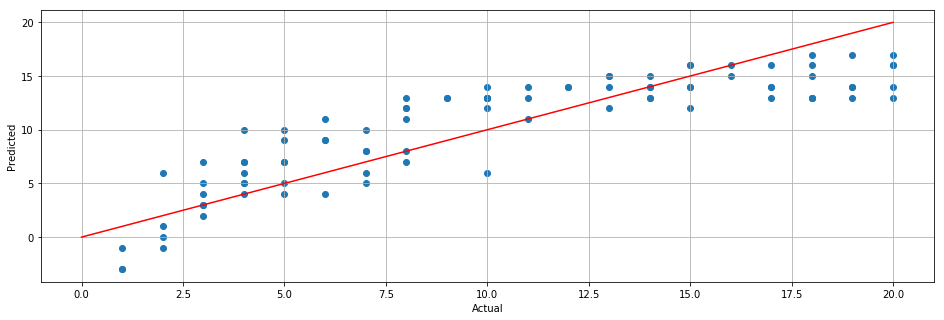

In [242]:
plt.scatter(ytr,ytr_pred)
plt.plot([0,20],[0,20],'r')
plt.xlabel('Actual',)
plt.ylabel('Predicted')

plt.grid()
plt.show()

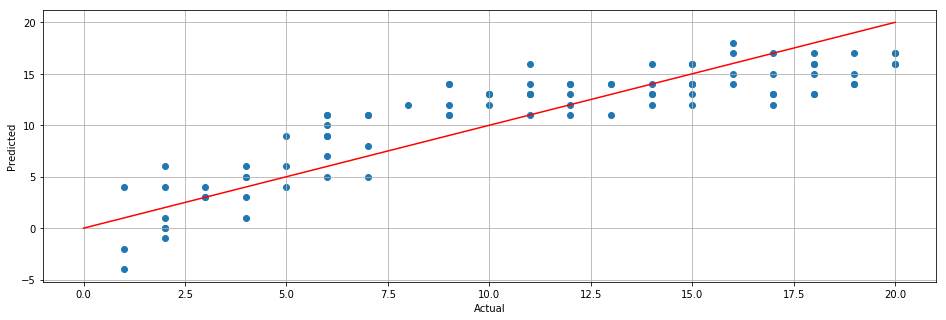

In [128]:
plt.scatter(yts,yts_pred)
plt.plot([0,20],[0,20],'r')
plt.xlabel('Actual',)
plt.ylabel('Predicted')

plt.grid()
plt.show()

The problem is also processed as a k-class classification problem, making each rank a bucket for the teams to fit in. However, the model doesn't give a better accuracy on the data.

In [243]:
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [244]:
mul_lr.fit(Xtr, ytr)

/Users/anasepetovska/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [245]:
ytr_pred_multi = np.rint(mul_lr.predict(Xtr))
acc = np.mean(ytr_pred_multi == ytr)
print("Accuracy on training data = %f" % acc)


Accuracy on training data = 0.366667


In [246]:
yts_pred_multi = np.rint(mul_lr.predict(Xts))
acc_ts = np.mean(yts_pred_multi == yts)
print("Accuracy on training data = %f" % acc_ts)

Accuracy on training data = 0.122222


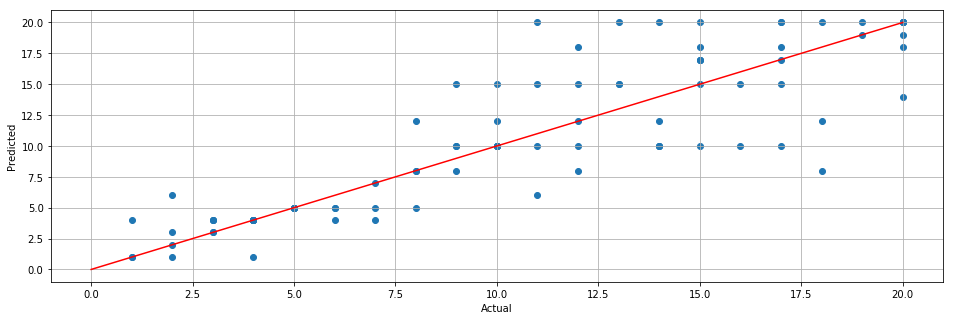

In [121]:
plt.scatter(ytr,ytr_pred_multi)
plt.plot([0,20],[0,20],'r')
plt.xlabel('Actual',)
plt.ylabel('Predicted')

plt.grid()
plt.show()

Just picking a random data point to see how the predictor will get for the current season Liverpool.

In [49]:
lfc = np.array([[82, 2, 2, 35, 233, 0.11]])
ylfc = regr.predict(lfc)
print(ylfc)

[1.75098315]


# Future Work
